# Sequence to Sequence LSTM

Acknowledgement : with the help of https://github.com/bentrevett/pytorch-seq2seq 


In [ ]:
!pip uninstall --yes torchtext

Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1


In [ ]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time, random, math, string

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
#from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

from torchtext.legacy import data
from torchtext.legacy import datasets
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import collections
import pandas as pd
import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# Any results you write to the current directory are saved as output.

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [ ]:
import torchtext

## Introduction

In this notebook, we will start simple model to understand the general concepts by implementing the model from the [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) paper.

The most common sequence-to-sequence (seq2seq) models are encoder-decoder models, which (commonly) use a recurrent neural network (RNN) to encode the source (input) sentence into a single vector (as an abstract representation of the entrie input sentence).

This vector is then decoded by a second RNN which learns to output the target(output) sentence by generating it one word at a time.

![](https://github.com/bentrevett/pytorch-seq2seq/raw/3a8dc5515ff28cb059532439c5687126dd30015f/assets/seq2seq1.png)
Above image shows an example translation. The input sentence "guten morgen", is input into the encoder (green) one word at a time. We also append a start of sequence(<sos\>) and end of sequence(<eos\>) token to the start and end of sentence, respectively. At each time-step, the input to the encoder RNN is both the current word $x_t$ as well as the hidden state from the previous time-step $h_{t-1}$ You can think of the hidden state as a vector representation of the sentence so far. The RNN can be represented as a function of both $x_t$ and $h_{t-1}$ :
$$
h_t = EncoderRNN(x_t, h_{t-1}) \tag{1}
$$
Here, we have $X={x_1, x_2, \cdots, x_T}$ where $x_1$ = <sos\> $x_2$ = guten, etc. The initial hidden states $h_0$ is usually either initialized to zeros or a learned parameter.

Once the final word $x_T$ has been passed into RNN, we use the final hidden state $h_T$ as the context vector i.e. $h_T = z$.
 
With our context vector $z$, we can start decoding it to get the target sentence, "good morning". Again we append start and end of sequence tokens to the target sentence. At each time-step, the input to the decoder RNN (blue) is the current word, $y_t$, as well as the hidden state from the previous time-step $s_{t-1}$, where the initail decoder hidden state $s_0 = z = h_T$ i.e. the initial hidden state is the final encoder hidden state. similar to the encoder, we can represent the decoder as:
$$
s_t = DecoderRNN(y_t, s_{t-1}) \tag{2}
$$
In the decoder, we need to go from the hidden state to an actual word, therefore at each time-step we use $s_t$ to predict (by passing it through a Linear layer, shown in purple) what we think is the next word in the sequence $\hat{y}_t$.
$$
\hat{y}_t = f(s_t) \tag{3}
$$
The word in the encoder are always generated one after another, with one per time-step. We always use the <sos\> for the first input to the decoder $y_1$, but for subsequent inputs $y_{t > 1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder $\hat{y}_{t-1}$. This is called teacher forcing.

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (i.e. real world usage) it is common to keep generating words until the model outputs an <eos\> token or after a certain amount of words have been generated.

Once we get our prediction $\hat{Y} = {\hat{y_1},\hat{y_2},\cdots, \hat{y_T}}$, we compare it against our actual target sentence $Y = {y_1, y_2, \cdots y_T}$, to calculate our loss. We then use this loss to update all of the parameters in our model.

## Preparing Data

In [ ]:
tokenizer = lambda x: str(x).translate(str.maketrans('', '', string.punctuation)).strip().split() 
reverse_tokenizer = lambda x: tokenizer(x)[::-1]

In [ ]:
minlim, maxlim = 7, 15

In [ ]:

!wget 'https://drive.google.com/uc?export=download&id=1qmAPy--y_6gP76PrjM0BCNeCIv3lSDwZ&confirm=T' -O dataset.zip
!rm -r dataset
!unzip dataset.zip
!rm dataset.zip

--2023-02-05 15:55:32--  https://drive.google.com/uc?export=download&id=1qmAPy--y_6gP76PrjM0BCNeCIv3lSDwZ&confirm=T
Resolving drive.google.com (drive.google.com)... 142.250.4.139, 142.250.4.138, 142.250.4.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2he6f1q71lk1nbd0ssalr18hm2k16can/1675612500000/11525140254639593309/*/1qmAPy--y_6gP76PrjM0BCNeCIv3lSDwZ?e=download&uuid=9deac040-1227-4138-ad36-69355a017a7f [following]
--2023-02-05 15:55:34--  https://doc-0k-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2he6f1q71lk1nbd0ssalr18hm2k16can/1675612500000/11525140254639593309/*/1qmAPy--y_6gP76PrjM0BCNeCIv3lSDwZ?e=download&uuid=9deac040-1227-4138-ad36-69355a017a7f
Resolving doc-0k-5g-docs.googleusercontent.com (doc-0k-5g-docs.googleusercontent.com)... 142.251.12.132,

In [ ]:
!git clone https://github.com/Text-Mining/Persian-Wikipedia-Corpus.git
!unzip Persian-Wikipedia-Corpus/models/glove/vectors.zip


Cloning into 'Persian-Wikipedia-Corpus'...
remote: Enumerating objects: 47, done.
remote: Total 47 (delta 0), reused 0 (delta 0), pack-reused 47
Unpacking objects: 100% (47/47), 758.15 MiB | 12.10 MiB/s, done.
Updating files: 100% (14/14), done.
Archive:  Persian-Wikipedia-Corpus/models/glove/vectors.zip
  inflating: vectors.txt             


In [ ]:
vocab,embeddings = [],[]
with open('vectors.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

In [ ]:

import numpy as np
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

In [ ]:

#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<unk>')
vocab_npa = np.insert(vocab_npa, 1, '<pad>')
vocab_npa = np.insert(vocab_npa, 2, '<sos>')
vocab_npa = np.insert(vocab_npa, 3, '<eos>')
print(vocab_npa[:10])

mean = np.mean(embs_npa,axis=0,keepdims=True)
variance = np.var(embs_npa,axis=0,keepdims=True)

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = mean + (2*np.random.rand(variance.shape[0],variance.shape[1])-1)*variance#np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.
sos_emb_npa = mean + (2*np.random.rand(variance.shape[0],variance.shape[1])-1)*variance
eos_emb_npa = mean + (2*np.random.rand(variance.shape[0],variance.shape[1])-1)*variance


#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((unk_emb_npa,pad_emb_npa,sos_emb_npa,eos_emb_npa,embs_npa))

['<unk>' '<pad>' '<sos>' '<eos>' 'در' 'و' '<NUM>' 'به' 'از' 'که']


In [ ]:
import torch
my_embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())

assert my_embedding_layer.weight.shape == embs_npa.shape
print(my_embedding_layer.weight.shape)

torch.Size([240552, 50])


In [ ]:
SRC = Field(tokenize=reverse_tokenizer, init_token='<sos>', eos_token='<eos>',fix_length = maxlim)
TRG = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True,fix_length = maxlim)


In [ ]:
fields = {'beyte1': ('src', SRC),'beyte2': ('trg', TRG)}

In [ ]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'dataset',
                                        train = 'train.csv',
                                        validation = 'valid.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = False
)

In [ ]:
# sher1
# sher2
# sher 3
# ->
# sher1,sher2
# sher2,sher3

In [ ]:
print(vars(train_data.examples[2]))

{'src': ['خم', 'رویینه', 'و', 'برکشیدند', 'جرس', 'گاودم', 'نالهٔ', 'و', 'آمد', 'خروش'], 'trg': ['سوی', 'شهر', 'ایران', 'نهادند', 'روی', 'سپاهی', 'بران', 'گونه', 'با', 'رنگ', 'و', 'بوی']}


In [ ]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 8543
Unique tokens in target (en) vocabulary: 8577


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

vocab,embeddings = [],[]
with open('vectors.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

#convert to numpy
import numpy as np
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<unk>')
vocab_npa = np.insert(vocab_npa, 1, '<pad>')
vocab_npa = np.insert(vocab_npa, 2, '<sos>')
vocab_npa = np.insert(vocab_npa, 3, '<eos>')
print(vocab_npa[:10])

mean = np.mean(embs_npa,axis=0,keepdims=True)
variance = np.var(embs_npa,axis=0,keepdims=True)

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = mean + (2*np.random.rand(variance.shape[0],variance.shape[1])-1)*variance
sos_emb_npa = mean + (2*np.random.rand(variance.shape[0],variance.shape[1])-1)*variance
eos_emb_npa = mean + (2*np.random.rand(variance.shape[0],variance.shape[1])-1)*variance


#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((unk_emb_npa,pad_emb_npa,sos_emb_npa,eos_emb_npa,embs_npa))
print(embs_npa.shape)



#convert to torch
embs_torch = torch.tensor(embs_npa,dtype=torch.float).to(device)

#mean & variance


# create vectors
indices = np.arange(len(embs_npa))
stoi_dict = {vocab_npa[i]:i for i in indices}
emb_dict = {vocab_npa[i]:embs_npa[i] for i in range(len(vocab_npa))}
SRC.vocab.set_vectors(stoi=stoi_dict,vectors=embs_torch,dim=50)
TRG.vocab.set_vectors(stoi=stoi_dict,vectors=embs_torch,dim=50)

['<unk>' '<pad>' '<sos>' '<eos>' 'در' 'و' '<NUM>' 'به' 'از' 'که']
(240552, 50)


In [ ]:

BATHC_SIZE = 128
# We use a BucketIterator instead of the standard Iterator as it create batches in such a way that it minimizes the amount 
# of padding in both the source and target sentences.
train_iter, valid_iter, test_iter = BucketIterator.splits((train_data, valid_data, test_data),
                                                          batch_size=BATHC_SIZE, device=device,sort_within_batch = True,
                                                          sort_key = lambda x: len(x.src))

In [ ]:
for i, batch in enumerate(train_iter):
    a = batch
    break


In [ ]:
a.trg.shape

torch.Size([15, 128])

## Building the Seq2Seq Model

We will build our model in three parts: The encoder, the decoder, and a seq2seq model that encapsulates the encoder and decoder. 

### Encoder 
First, the encoder, a 2 layer LSTM. The paper we are implementing uses a 4-layer LSTM, but in the interest of training time we cut down to 2-layers. The concept of multi-layer RNN is easy to expand from 2 to 4 layers.

For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hiddne states, $H=\{h_1, h_2, \cdots,h_T\}$ output by this layer are used as inputs to the RNN in the layer above. Thus representing each layer with a superscript, the hidden states in the first layer are given by :
$$
h_t^1 = EncoderRNN^1(x_t, h_{t-1}^1) \tag{4}
$$
The hidden states in the second layer are given by:
$$
h_t^2 = EncoderRNN^2(h_t^1, h_{t-1}^2) \tag{5} 
$$
Using a multi-layer RNN also means we'll also need an initial hidden state as input per layer, $h_0^l$, and we will also output a context vector per layer $z^l$

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout,SRC_Field):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        #self.embedding = nn.Embedding(input_dim, emb_dim)
        self.embedding = nn.Embedding.from_pretrained(SRC_Field.vocab.vectors, freeze=False)

        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        # src : [sen_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        
        # embedded : [sen_len, batch_size, emb_dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [sen_len, batch_size, hid_dim * n_directions]
        # hidden = [n_layers * n_direction, batch_size, hid_dim]
        # cell = [n_layers * n_direction, batch_size, hid_dim]
        return hidden, cell

### Decoder

Next, we will build our decoder. which also be a 2-layer LSTM.

![](https://github.com/bentrevett/pytorch-seq2seq/raw/3a8dc5515ff28cb059532439c5687126dd30015f/assets/seq2seq3.png)

We can use the following equations to explain the decoder model.
$$
(s_t^1, c_t^1) = DecoderLSTM^1(y_t, (s_{t-1}^1, c_{t-1}^1))
$$
$$
(s_t^2, c_t^2) = DecoderLSTM^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
$$
Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell of our encoder from the same layer. i.e. $(s_0^l, c_0^l) = z^l = (h_T^l, c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^2$ through a linear layer $f$, to make a prediction of what the next token in the target (output) sequence should be $\hat{y}_{t+1}$
$$
\hat{y}_{t+1} = f(s_t^2) 
$$

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout,TRG_Field):
        super().__init__()
        
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        #self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding = nn.Embedding.from_pretrained(TRG_Field.vocab.vectors, freeze=False)

        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=self.n_layers, dropout=dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        # input = [batch_size]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        input = input.unsqueeze(0)
        # input : [1, ,batch_size]
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq_len, batch_size, hid_dim * n_dir]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        # seq_len and n_dir will always be 1 in the decoder
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch_size, output_dim]
        return prediction, hidden, cell

### Seq2Seq
For the final part of the implementation, we will implement the seq2seq model.

- receive the input/source sentence

- using the encoder to produce the context vectors

- using the decoder to produce the predicted output / target sentence.

Our full model will look like this:

![](https://github.com/bentrevett/pytorch-seq2seq/raw/3a8dc5515ff28cb059532439c5687126dd30015f/assets/seq2seq4.png)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            'hidden dimensions of encoder and decoder must be equal.'
        assert encoder.n_layers == decoder.n_layers, \
            'n_layers of encoder and decoder must be equal.'
        
    def forward(self, src, trg, teacher_forcing_ratio=1):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = trg[0, :]
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = trg[t] if teacher_force else top1
            
        return outputs
        
    def inference(self, src,maxlim=15):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.
        batch_size = src.shape[1]
        trg_len = maxlim
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = (torch.ones((batch_size),dtype=torch.long)*2).to(device)
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = top1
            
        return outputs


In [ ]:
SRC.vocab.stoi['<sos>']

2

## Training the Seq2Seq model


In [ ]:
# First initialize our model.
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 50
DEC_EMB_DIM = 50
HID_DIM = 128
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT,SRC)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT,TRG)

model = Seq2Seq(encoder, decoder, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8543, 50)
    (rnn): LSTM(50, 128, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(8577, 50)
    (rnn): LSTM(50, 128, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=128, out_features=8577, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,410,945 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

Next, we'll define our training loop.

First. we'll set the model into "training mode" (turn on the dropout & batch normalization), and then iterate through our data iterator.

As stated before, our decoder loop starts at 1, not 0. This means the 0th element of our outputs tensor remains all zeros. So our trg & outputs look something like:
$$
trg = [<sos>, y_1, y_2, y_3, <eos>]
$$
$$
output = [0, \hat{y}_1,\hat{y}_2,\hat{y}_3, <eos>]
$$
Here, when we calculate the loss, we cut off the first element of each tensor to get:
$$
trg = [y_1, y_2, y_3, <eos>]
$$
$$
output = [\hat{y}_1,\hat{y}_2,\hat{y}_3, <eos>]
$$
At each iterator:

- get the source and target sentences from the batch, X and Y

- zero the gradients calculated from the last batch
 
- feed the source and target into the model to get the output $\hat{y}$

- as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with .view
    - we slice off the first column of the output and target tensors as mentioned above.
    
- calculate the gradients with loss.backward()

- clip the gradients to prevent them from exploding (a common issue in RNNs)

- update the parameters of our model by doing an optimizer.step()

- sum the loss value to a running total.

Finally, we return the loss that is average over all batches.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    epoch_acc = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        # trg = [sen_len, batch_size]
        # output = [trg_len, batch_size, output_dim]
        output = model(src, trg)

        output_index = output.argmax(2)
        acc = (torch.sum(output_index==trg)/torch.numel(output_index)).item()

        epoch_acc += acc
        output_dim = output.shape[-1]
        
        # transfrom our output : slice off the first column, and flatten the output into 2 dim.
        output = output[1:].view(-1, output_dim) 
        trg = trg[1:].view(-1)
        # trg = [(trg_len-1) * batch_size]
        # output = [(trg_len-1) * batch_size, output_dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator),epoch_acc/ len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        
        for i, batch in enumerate(iterator):
            
            src = batch.src
            trg = batch.trg
            
            output = model(src, trg, 0) # turn off teacher forcing.
            output_index = output.argmax(2)
            acc = (torch.sum(output_index==trg)/torch.numel(output_index)).item()
            epoch_acc += acc
            # trg = [sen_len, batch_size]
            # output = [sen_len, batch_size, output_dim]
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator),epoch_acc/ len(iterator)

In [ ]:
# a function that used to tell us how long an epoch takes.
def epoch_time(start_time, end_time):
    
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time  / 60)
    elapsed_secs = int(elapsed_time -  (elapsed_mins * 60))
    return  elapsed_mins, elapsed_secs

In [ ]:
history = collections.defaultdict(list)
N_EPOCHS = 30
save_every = 3
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss,train_acc = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss,valid_acc = evaluate(model, valid_iter, criterion)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)
    history['val_acc'].append(valid_acc)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Seq2SeqModel.pt')
    if epoch%save_every == 0:
      torch.save(model.state_dict(), f'Seq2SeqModel{epoch:02d}.pt')
      data = str(history)
      with open(f'losses{epoch:02d}.txt','wt') as f:
        f.write(data)

      
    print(f"Epoch: {epoch+1:02} | Time {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}")

Epoch: 01 | Time 0m 16s
	Train Loss: 6.622 | Train PPL: 751.583
	Valid Loss: 6.373 | Valid PPL: 586.025
Epoch: 02 | Time 0m 16s
	Train Loss: 6.250 | Train PPL: 518.120
	Valid Loss: 6.741 | Valid PPL: 846.631
Epoch: 03 | Time 0m 16s
	Train Loss: 6.076 | Train PPL: 435.368
	Valid Loss: 6.600 | Valid PPL: 735.114
Epoch: 04 | Time 0m 16s
	Train Loss: 5.918 | Train PPL: 371.505
	Valid Loss: 6.747 | Valid PPL: 851.550
Epoch: 05 | Time 0m 16s
	Train Loss: 5.801 | Train PPL: 330.567
	Valid Loss: 6.701 | Valid PPL: 812.980
Epoch: 06 | Time 0m 16s
	Train Loss: 5.719 | Train PPL: 304.652
	Valid Loss: 6.779 | Valid PPL: 879.213
Epoch: 07 | Time 0m 16s
	Train Loss: 5.651 | Train PPL: 284.716
	Valid Loss: 6.810 | Valid PPL: 907.081
Epoch: 08 | Time 0m 16s
	Train Loss: 5.590 | Train PPL: 267.668
	Valid Loss: 6.919 | Valid PPL: 1011.776
Epoch: 09 | Time 0m 16s
	Train Loss: 5.533 | Train PPL: 252.926
	Valid Loss: 6.957 | Valid PPL: 1050.118
Epoch: 10 | Time 0m 16s
	Train Loss: 5.475 | Train PPL: 238.67

In [ ]:
"""
model.train()

epoch_loss = 0
clip = 1

for i, batch in enumerate(train_iter):
    src = batch.src
    trg = batch.trg
    
    optimizer.zero_grad()
    # trg = [sen_len, batch_size]
    # output = [trg_len, batch_size, output_dim]
    output = model(src, trg)
    output_index = output.argmax(2)
    acc = (torch.sum(output_index==trg)/torch.numel(output_index)).item()
    output_dim = output.shape[-1]
    
    # transfrom our output : slice off the first column, and flatten the output into 2 dim.
    output = output[1:].view(-1, output_dim) 
    trg = trg[1:].view(-1)
    # trg = [(trg_len-1) * batch_size]
    # output = [(trg_len-1) * batch_size, output_dim]
    
    loss = criterion(output, trg)
    
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    
    optimizer.step()
    
    epoch_loss += loss.item()
  """

In [ ]:
for i, batch in enumerate(test_iter):
    src = batch.src
    break


In [ ]:
output = model.inference(src,maxlim=15)
out = output.argmax(2)
out_text = [TRG.vocab.itos[idx] for idx in out[:,27] ]
print(out_text)

['<unk>', 'چو', 'بشنید', 'و', '<unk>', 'و', '<unk>', 'که', 'از', '<unk>', 'و', '<unk>', 'و', 'سپاه', '<eos>']


In [ ]:
def test():
    best_model = Seq2Seq(encoder, decoder, device).to(device)
    best_model.load_state_dict(torch.load('Seq2SeqModel.pt'))
    
    test_loss = evaluate(model, test_iter, criterion)
    
    print(f"Test Loss : {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}")
    
test()

In [8]:
!wget 'https://drive.google.com/uc?export=download&id=1-5oBzjXPRRJGrrVoItRlKqg6K-v9aQNr&confirm=T' -O loss.txt

--2023-02-05 17:47:09--  https://drive.google.com/uc?export=download&id=1-5oBzjXPRRJGrrVoItRlKqg6K-v9aQNr&confirm=T
Resolving drive.google.com (drive.google.com)... 142.250.136.138, 142.250.136.102, 142.250.136.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.136.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vteqha7qbinuli9f2febv0da0jsri1bl/1675619175000/11525140254639593309/*/1-5oBzjXPRRJGrrVoItRlKqg6K-v9aQNr?e=download&uuid=19d5f0af-a0a3-4c6e-b006-a22cd23c5a86 [following]
--2023-02-05 17:47:10--  https://doc-0s-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vteqha7qbinuli9f2febv0da0jsri1bl/1675619175000/11525140254639593309/*/1-5oBzjXPRRJGrrVoItRlKqg6K-v9aQNr?e=download&uuid=19d5f0af-a0a3-4c6e-b006-a22cd23c5a86
Resolving doc-0s-5g-docs.googleusercontent.com (doc-0s-5g-docs.googleusercontent.com)... 74.125.

In [3]:
import re

In [9]:
with open('loss.txt','rt') as f:
  str_data = f.readlines()

In [60]:
x = re.findall("\[[^\]]+\]", str_data[0])

In [44]:
import numpy as np
from matplotlib import pyplot as plt

In [64]:
train_acc = np.array([float(stritem) for stritem in x[0][1:-1].split(',')])
train_loss = np.array([float(stritem) for stritem in x[1][1:-1].split(',')])
val_loss = np.array([float(stritem) for stritem in x[2][1:-1].split(',')])
val_acc = np.array([float(stritem) for stritem in x[3][1:-1].split(',')])

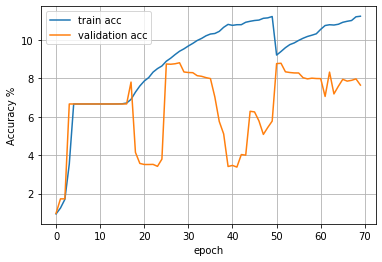

In [66]:
plt.plot(train_acc*100,label='train acc')
plt.plot(val_acc*100,label='validation acc')
plt.xlabel('epoch')
plt.ylabel('Accuracy %')
plt.grid()
plt.legend()

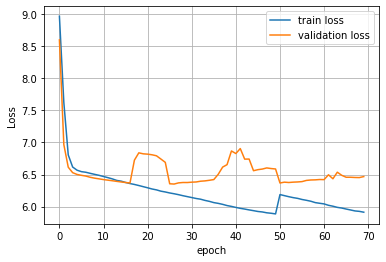

In [69]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='validation loss')
plt.xlabel('epoch'); plt.ylabel('Loss');
plt.grid(); plt.legend();

## Summary 

Through the model is tranditional Seq2Seq model as the author mentioned before. As a beginner of pytorch and deeplearning, there is also many useful tricks worth learning. As a notebook I list them below:

### Data Preparing Part

- In the original paper, they find it beneficial to reverse the order of the input which they believe "introduces many short term dependencies in the data that make the optimization problem much easier". 

it means when we want to get the context vector, it is beneficial to reverse the order of the input.

- When build the vocabulary we can use min_freq parameter to remove the rare words in the corpus.

e.g. SRC.build_vocab(train_data, min_freq=2)

### Seq2Seq Model Part

- In this notebook, we can learn how to build a deeplearning pipeline (seperate our model into different parts.) and combine them together.

- It is a traditional Seq2Seq model, encoder is used to get the context vectors represented by the hidden and cell state generated by the last layer of LSTM. While decoder initialize its $h_0, c_0$ according to the encoder output. And each time-step $t$, generate the $t+1$ word in the target sentence. update the input according to the previous word and the teacher_force rate.

- This is the first time I have ever seen the teacher_force rate. It is just a simple but useful way to restinct the changing of our model.

### Train Part

- Clip : as mentioned before, before we use optimizer.step(), we should use  torch.nn.utils.clip_grad_norm_(model.parameters(), clip) to avoiding gradients exploding ! Here we set clip=1. 

# GRU

In [ ]:
class EncoderGRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout,SRC_Field):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        #self.embedding = nn.Embedding(input_dim, emb_dim)
        self.embedding = nn.Embedding.from_pretrained(SRC_Field.vocab.vectors, freeze=False)

        self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout,bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        # src : [sen_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        
        # embedded : [sen_len, batch_size, emb_dim]
        outputs, hidden = self.rnn(embedded)
        # outputs = [sen_len, batch_size, hid_dim * n_directions]
        # hidden = [n_layers * n_direction, batch_size, hid_dim]
        # cell = [n_layers * n_direction, batch_size, hid_dim]
        return hidden

In [ ]:
class DecoderGRU(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout,TRG_Field):
        super().__init__()
        
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        #self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding = nn.Embedding.from_pretrained(TRG_Field.vocab.vectors, freeze=False)

        self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=self.n_layers, dropout=dropout,bidirectional=True)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
        
        # input = [batch_size]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        input = input.unsqueeze(0)
        # input : [1, ,batch_size]
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]
        
        output, hidden= self.rnn(embedded, hidden)
        # output = [seq_len, batch_size, hid_dim * n_dir]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        # seq_len and n_dir will always be 1 in the decoder
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch_size, output_dim]
        return prediction, hidden

In [ ]:
class Seq2SeqGRU(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            'hidden dimensions of encoder and decoder must be equal.'
        assert encoder.n_layers == decoder.n_layers, \
            'n_layers of encoder and decoder must be equal.'
        
    def forward(self, src, trg, teacher_forcing_ratio=1):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = trg[0, :]
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden = self.decoder(input, hidden)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = trg[t] if teacher_force else top1
            
        return outputs
        
    def inference(self, src,maxlim=15):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.
        batch_size = src.shape[1]
        trg_len = maxlim
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = (torch.ones((batch_size),dtype=torch.long)*2).to(device)
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden = self.decoder(input, hidden)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = top1
            
        return outputs


In [ ]:
# First initialize our model.
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 50
DEC_EMB_DIM = 50
HID_DIM = 128
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encodergru = EncoderGRU(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT,SRC)
decodergru = DecoderGRU(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT,TRG)

modelgru = Seq2SeqGRU(encodergru, decodergru, device).to(device)

In [ ]:
optimizer = optim.Adam(modelgru.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)


In [ ]:
history = collections.defaultdict(list)
N_EPOCHS = 10
save_every = 3
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss,train_acc = train(modelgru, train_iter, optimizer, criterion, CLIP)
    valid_loss,valid_acc = evaluate(modelgru, valid_iter, criterion)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)
    history['val_acc'].append(valid_acc)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelgru.state_dict(), 'Seq2SeqModelGRU.pt')
    if epoch%save_every == 0:
      torch.save(modelgru.state_dict(), f'Seq2SeqModelGRU{epoch:02d}.pt')
      data = str(history)
      with open(f'lossesGRU{epoch:02d}.txt','wt') as f:
        f.write(data)

      
    print(f"Epoch: {epoch+1:02} | Time {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}")